# La Classification Quantique Variationnelle avec Qiskit

In [1]:
from qiskit import generate_preset_pass_manager
from qiskit.circuit.library import ZZFeatureMap, TwoLocal, RealAmplitudes

from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
from qiskit_ibm_runtime import SamplerV2 as Sampler

from qiskit_machine_learning.optimizers import COBYLA, SPSA

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Les données utilisées pour le modèle

Afin de créer notre modèle d’intelligence artificielle il va falloir utiliser des données. Nous allons recourir au jeu de données Iris qui est un des plus populaires pour la formation en IA. Il a la particularité d’avoir des données nettoyées et préparées pour l’apprentissage automatique ainsi que d’avoir des attributs bien distincts entre eux. Par conséquent les algorithmes de classification classiques qui résultent de ce jeu de données sont très performants.

Iris est composé de 5 colonnes au total. Les 4 premières colonnes correspondent à des attributs physiques de plusieurs fleurs de genre iris. Parmi ces attributs physiques nous avons:

- La longueur du sépale en cm
- La largeur du sépale en cm
- La longue du pétale en cm
- La largeur du pétale en cm

La dernière colonne correspond à la variété d’iris et elle a trois valeurs possibles: Setosa, Versicolor ou Virginica. Le jeu de données à également une excellente répartition des données car les 150 enregistrements sont réparties de manière équilibrées entre les variétés d’iris. Il y a donc 50 lignes pour chacune des trois variétés.

Pour pouvoir charger facilement le jeu de données nous allons utiliser la fonction load_iris() de la librairie Scikit-learn spécialisée dans les algorithmes d’apprentissage automatique. Dans la variable X nous allons stocker les données qui vont servir à entraîner le modèle, et dans la variable y nous stockons les labels correspondant.

In [2]:
# X contient les données d'entraînement
# y contient les labels
X, y = load_iris(return_X_y=True, as_frame=True)

# On en profite pour stocker les noms des colonnes dans une variable
# columns qui sera utilisée plus tard
columns = X.columns

Une fois les données chargées nous allons les normaliser grâce à la classe MinMaxScaler() de Scikit-learn pour qu’elles puissent toutes avoir une valeur comprise sur l’intervale [0, 1]. Cette étape de normalisation n’est pas obligatoire mais elle souvent utilisée en apprentissage automatique car elle permet souvent d’otenir de meilleurs résultats grâce à une meilleure convergence de l’algorithme. De plus il va falloir encoder ces données dans un circuit quantique et la normalisation va également améliorer l’encodage.

In [3]:
# On normalise les données stockées dans la variable X
X = MinMaxScaler().fit_transform(X)

Pour finir nous allons formater et visualiser les données grâce aux librairies Pandas et Seaborn.

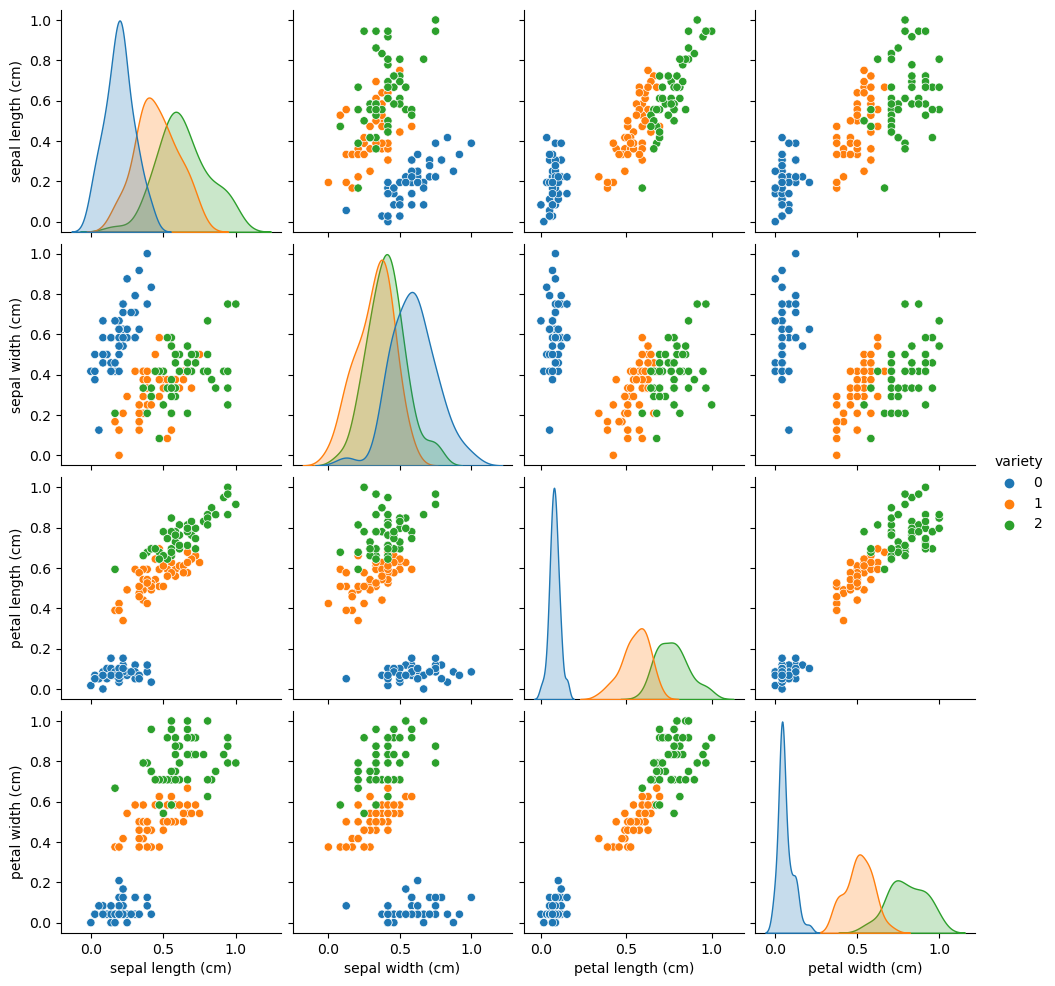

In [4]:
dataframe = pd.DataFrame(X, columns=columns)
dataframe["variety"] = pd.Series(y)

sns.pairplot(dataframe, hue="variety", palette="tab10")

On observe des nuages de points bien distincts entre eux et que les données ont bien été normalisées. 

Il nous reste à diviser nos données en jeu d'entraînement et de test avant de créer notre premier modèle d’intelligence artificielle quantique.

In [5]:
# X_train stocke les données d'entraînement
# X_test contient les données de test
# y_train stocke les labels d'entraînement
# y_test contient les labels de test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

## La Classification Quantique Variationnelle

En informatique quantique il existe plusieurs algorithmes pour créer des modèles d’intelligence artificielle. Celui qui a été choisi pour cet article est l’algorithme de Classification Quantique Variationnelle, abrégée VQC en anglais.

### Principe de fonctionnement

#### Le circuit archétype

Le principe de la VQC est de créer un circuit qui va servir d'archétype. C’est un circuit variationnel, aussi appelé circuit paramétré, qui aura des variables libres que l'on enrichira. Cet archétype va permettre de créer autant de circuits quantiques qu'il y a d'enregistrement dans le jeu de données, 150 pour notre jeu de données. Les circuits vont accueillir des paramètres d'ajustement qui permettront d’entraîner notre modèle.


Le circuit archétype sera divisé en trois parties:

- L'état de référence: Elle encode les données dans un circuit quantique. Le nombre de qubits de l'état de référence est égal au nombre d'attributs du jeu de données. Iris a 4 attributs, le circuit aura 4 qubits. L’état de référence sera différent pour chaque circuit d’une itération.
- L'ansatz: Elle accueille les paramètres d'ajustement du modèle quantique. L’ansatz sera le même pour tous les circuits sur une même itération.
- La mesure: Elle permet de mesurer les qubits et de les enregistrer sur un bit classique.

![Image du circuit](./images/schema-archetype.png "Title")

Sur le schéma, la variable x correspond à l'ensemble des valeurs de l'enregistrement et la variable  correspond à l'ensemble des paramètres d'ajustement.

#### L'agorithme de la VQC

Le principe de la VQC va être de créer un circuit paramétré qui va servir d'archétype. Ce sera un circuit variationnel, aussi appelé circuit paramétré, qui aura des variables libres que l’on enrichira par la suite. Cet archétype va permettre de créer autant de circuits quantiques qu’il y a d’enregistrement dans le jeu de données. Le jeu de données de l’iris compte 150 lignes, nous allons donc créer 150 circuits. Les circuits vont également accueillir des paramètres d’ajustement qui vont servir à l’entraînement du modèle. C’est un principe familier sur certains algorithmes d’apprentissage automatique: on définit des paramètres d’ajustement qui vont entraîner notre modèle une première fois, puis qui seront ajustés avec un optimiseur pour l’entraîner une deuxième fois avec les nouveaus paramètres. Cette itération sera répétée jusqu’à obtenir un résultat optimal. Une fois que les paramètres d’ajustement auront atteint leur valeur finale, le circuit qui en résultera correspondra à notre modèle d’intelligence artificielle.

À la fin de chaque itération les circuits seront mesurés. Chaque mesure sera stockée sur des bits classiques et l’optimisation des paramètres d’ajustement se fera à l’aide d’un optimiseur sur un ordinateur classique avant d’être réencodé dans un circuit quantique pour l’itération suivante. Cette alternance entre ordinateur classique et quantique définit notre système comme étant hybride. Voici un schéma pour illustrer le processus d’entraînement d’un circuit quantique.

![Workflow](./images/processus.png "Title")

#### L'état de référence

L’état de référence va nous permettre d’encoder nos données et pour chaque circuit correspondant aux enregistrements nous allons avoir un état de référence différent. Il existe différent patron de circuit quantique pour les états de référence. Un des plus utilisés est le feature map et peut-être implémenté grâce à la classe ZZFeatureMap de Qiskit. Le nombre de qubits utilisé dans le circuit va être égal au nombres d’attributs (features en anglais) de notre jeu de données.

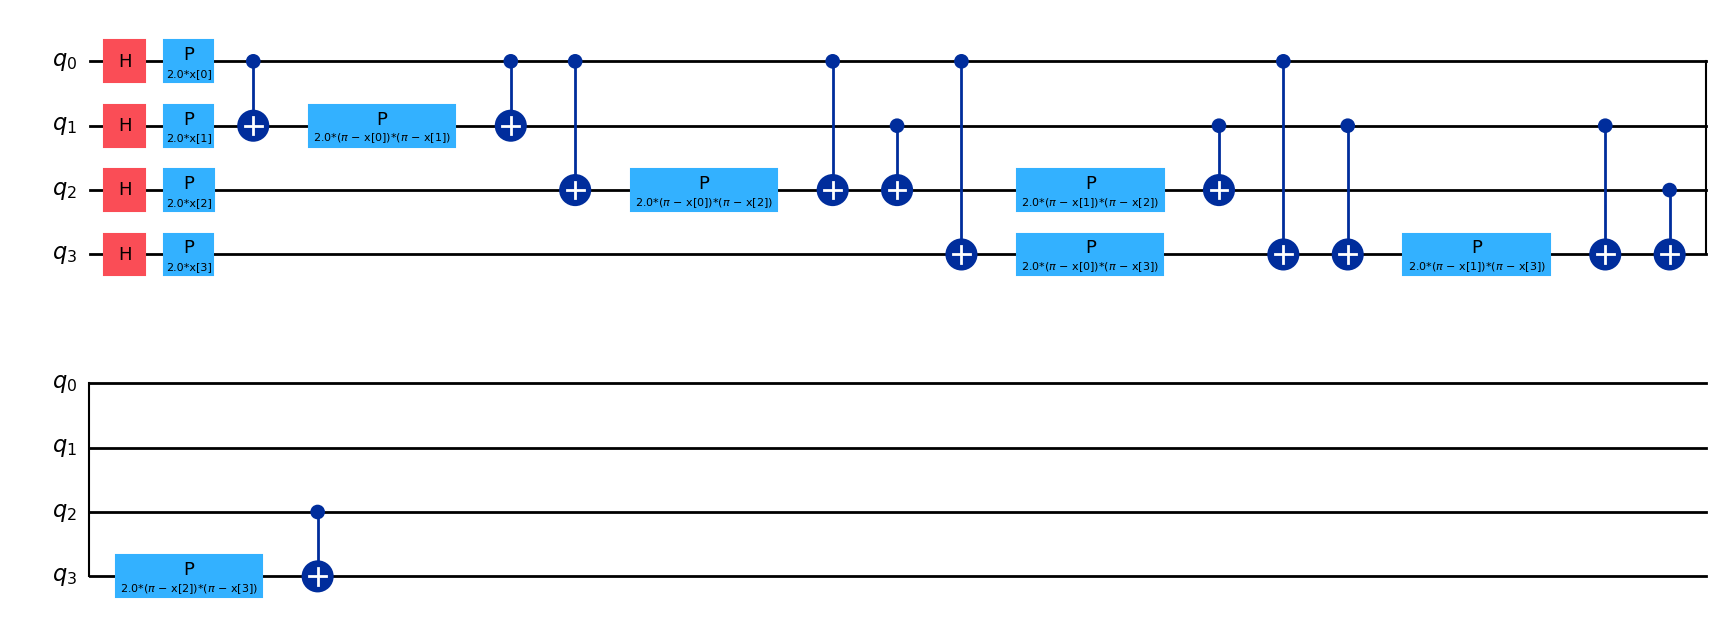

In [6]:
# On récupère le nombre d'attributs
# number_of_features = X.shape[1]
number_of_features = X_train.shape[1]

feature_map = ZZFeatureMap(feature_dimension=number_of_features, reps=1)
feature_map.decompose().draw(output="mpl")

À ce stade aucune information du jeu de données n’est encodée dans le circuit, il est inutilisable en l’état. Si on regarde attentivement l’image du circuit on peut observer qu’il y a 4 paramètres $x[0]$, $x[1]$, $x[2]$ et $x[3]$ qui correspondent aux valeurs de nos attributs, les largeurs et longueurs des pétales et des sépales dans notre cas. Ce sont ces paramètres qui vont accueillir les valeurs des attributs.

#### L'ansatz

L’ansatz va nous permettre d’encoder nos paramètres d’ajustement. Tout comme l’état de référence, il existe différents partons de circuit quantique pour l’ansatz. Nous allons utilisé la classe RealAmplitudes de Qiskit mais il existe d’autres circuits qui peuvent jouer ce rôle.

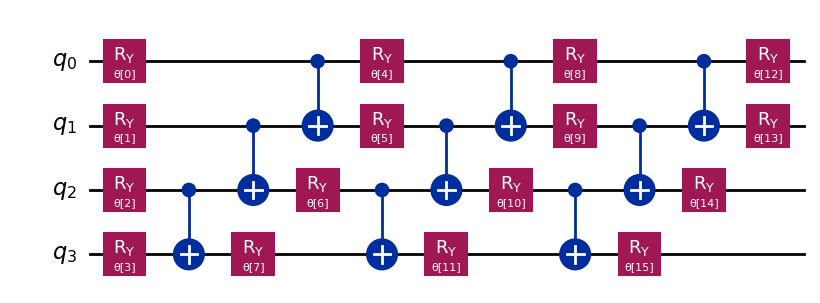

In [7]:
ansatz = RealAmplitudes(num_qubits=number_of_features, reps=3)
ansatz.decompose().draw(output="mpl")

Ici aussi aucun paramètres d’ajustement n’a été ajouté. Si on regarde l’image du circuit on peut observer qu’il y a 16 paramètres allant de $\theta[0]$ à $\theta[15]$ qui correspondent aux valeurs des paramètres d’ajustement. Ce sont ces paramètres qui vont accueillir les valeurs des paramètres d’ajustement.

#### La mesure

Nous allons mesurer la chaîne de qubits grâce à la méthode `measure_all()` du circuit.

## Préparation de l'environnement

### L'ordinateur quantique

Dans un premier temps, nous allons utiliser un simulateur.

In [8]:
# Utilisation d'un simulateur
backend = FakeAlmadenV2()

### La primitive

L’arrivée de Qiskit 1.0 a introduit la notion de primitives qui ont ajouté une nouvelle approche d’interagir avec les ordinateurs quantiques. Les primitives proposent deux approches différentes grâce à deux classes différentes.

- La classe Sampler qui permet de récupérer les mesures des circuits à l’état brut. C’est la classe que nous allons utiliser.
- La classe Estimator qui permet d’obtenir la valeur attendue d’une observable appliquée sur un ou plusieurs qubits.

Nous allons utiliser un sampler avec le backend choisi.

In [9]:
# Création d'un sampler avec le backend utilisé
sampler = Sampler(mode=backend)

### Le pass manager

Les circuits que nous avons utilisé sont optimaux pour nous mais ne le sont pas pour l’ordinateur quantique. Il va falloir le compiler pour pouvoir l’adapter à l’architecture de l’ordinateur quantique choisi. Pour cela nous allons utiliser un pass manager fourni par Qiskit IBM Runtime.

In [10]:
pass_manager = generate_preset_pass_manager(
    backend=backend, 
    optimization_level=1 # Permet de supprimer les erreurs
)

### L'optimiseur

Il nous reste à choisir un optimiseur qui va s’occuper d’affiner les paramètres d’ajustement à chaque itération. Parmi les nombreux existants nous allons utilisé COBYLA qui est mis à disposition avec Qiskit Machine Learning.

In [11]:
optimizer = COBYLA(maxiter=100)

Jusqu’ici nous avons préparé un état de référence, un ansatz, un pass manager, un sampler et un optimiseur. Nous avons tous les éléments nécessaires pour créer notre modèle d’intelligence artificielle.

## Création du classifieur quantique

Nous allons créer différentes fonctions avec Python qui vont résumer les différentes étapes du workflow. La première étape est de créer le patron de circuit dans sa globalité en combinant l'état de référence, l'ansatz et la mesure.

In [12]:
def generate_circuit_pattern(reference_state, ansatz):
    """
    Génère un patron de circuit quantique à partir d'un état de référence et d'un ansatz
    :param reference_state:
    :param ansatz:
    :return: Un patron de circuit quantique
    """
    circuit_pattern = reference_state.compose(ansatz)
    circuit_pattern.measure_all()
    return circuit_pattern

La deuxième fonction va permettre de générer un circuit à partir d'un enregistrement du jeu de données et des paramètres d'ajustement. Elle va avoir en paramètre le patron de circuit dans sa globalité, les paramètres de l'état de référence, les paramètres de l'ansatz, les valeurs d'un enregistrement du jeu de données à relier avec l'état de référence et les valeurs des paramètres d'ajustement à relier avec l'ansatz.  

In [13]:
def hydrate_circuit_pattern_with_data_and_tunable_parameters(
        circuit_pattern,
        reference_state_parameters,
        ansatz_parameters,
        data,
        tunable_parameters
):
    """
    Génère un circuit quantique à partir d'un circuit pattern et des données à lui affilier
    Args:
        circuit_pattern (QuantumCircuit): Circuit paramétré à enrichir
        reference_state_parameters (list): List des paramètres de l'état de référence,
        ansatz_parameters (list): List des paramètres de l'ansatz,
        data (list): Données pour l'état de référence
        parameter_values (list): Valeurs pour les paramètres de la forme variationnelle
    Returns:
        QuantumCircuit: L'ansatz avec les paramètres assigné
    """
    parameters = {}
    for index, parameter in enumerate(reference_state_parameters):
        parameters[parameter] = data[index]
    for index, parameter in enumerate(ansatz_parameters):
        parameters[parameter] = tunable_parameters[index]
    return circuit_pattern.assign_parameters(parameters)

Nous allons maintenant nous intéresser à la partie d'analyse des mesures. L'ordinateur quantique va exécuter chaque circuits des milliers de fois et en faire des mesures. Dans notre cas nous allons obtenir des chaînes de bits en sortie et nous voulons les convertir en classe. Pour cela nous allons utiliser le poid de Hamming.

In [14]:
def parity(bitstring):
    """
    On utilise le poids de Hamming pour déterminer le label déterminé.
    Retourne 0, 1 ou 2.
    """
    hamming_weight = sum(int(k) for k in list(bitstring))
    parity = (hamming_weight + 1) % 3
    return parity

Nous allons ensuite créer une fonction qui prend en paramètre les résultats des mesures de l'ordinateur quantique pour pouvoir ensuite déterminer la distribution de probabilités des classe 0, 1 ou 2 (Setosa, Versicolor ou Virginica) pour chaque circuit.

In [15]:
def label_probabilities(result):
    """
    Convertit un dictionnaire de chaînes de bits et leur comptage
    en leur parité et leur comptage
    """
    num_shots = result.data.meas.num_shots
    counts_results = result.data.meas.get_counts()
    probabilities = {0: 0, 1: 0, 2: 0}
    for bitstring, counts in counts_results.items():
        label = parity(bitstring)
        probabilities[label] += counts / num_shots
    return probabilities

La fonction suivante va permettre de calculer la perte en fonction de la probabilité d'avoir obtenu la bonne classification.

In [16]:
import numpy as np

def cross_entropy_loss(classification, expected):
    """
    Calcule la perte d'entropie croisée
    Args:
        classification (dict): Dictionnaire où les clefs sont les classes possibles et les valeurs sont la probabilité d'obtenir cette classe. 
        expected (int): Label attendu de l'enregistrement.
    Returns:
        float: Perte d'entrope croisée
    """
    # Probabilité d'une classification correcte
    probability = classification.get(expected)
    loss = -np.log(probability + 1e-10)
    return loss

Il nous reste à créer une fonction qui va calculer le coût total en sommant la perte d'entropie croisée de chaque circuit.

In [17]:
def cost_function(classifications, data, labels):
    """
    Calcule le coût total
    Args:
        classifications (dict): Dictionnaire où les clefs sont les classes possibles et les valeurs sont la probabilité d'obtenir cette classe.
        data (list): Liste contenant les données d'entraînements.
        labels (list): Liste contenant les labels d'entraînements.
    Returns:
        float: Coût total
    """
    cost = 0
    for index, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[index])
    cost /= len(data)
    return cost

Il nous reste à créer la fonction qui correspondra à une itération et qui reprend le workflow de la Classification Variationnelle Quantique.

In [18]:
def iteration(tunable_parameters):
    """
    Fonction qui permet de créer une itération du processus de
    la Classification Quantique Variationnelle
    Args:
        tunable_parameters (list): Paramètres d'ajustement
    Returns:
        float: Coût total
    """
    # 1 - Construction des circuits
    # La construction des circuits comprend le circuit non-paramétré
    # Puis l'affiliation des paramètres en fonction du jeu de données
    circuit_pattern = generate_circuit_pattern(feature_map, ansatz)
    circuits = [
        hydrate_circuit_pattern_with_data_and_tunable_parameters(
            circuit_pattern,
            feature_map.ordered_parameters,
            ansatz.ordered_parameters,
            data,
            tunable_parameters
        ) for data in X_train
    ]

    # 2 - Transformation en ISA
    pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuits = [pass_manager.run(circuit) for circuit in circuits]

    # 3 - Execution sur un backend
    sampler = Sampler(mode=backend)
    job = sampler.run(isa_circuits)

    # 4 - Analyse des résultats
    results = job.result()
    # On convertit les résultats bruts en distribution de probabilités de classification
    classifications = [label_probabilities(result) for result in results]
    # On calcule le coût
    cost = cost_function(classifications, X_train, y_train)

    return cost

## Entraînement du circuit

Il nous reste à entraîner le circuit grâce à un optimiseur. Afin de suivre l'évolution de l'entraînement nous créons une classe qui va permettre d'afficher le coût de la fonction.

In [19]:
class OptimizerLog:  # pylint: disable=too-few-public-methods
    """
        Classe permettant de stocker les résultats intermédiaires de l'optimiseur
    """
    
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
        
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """
        Méthode permettant de stocker les résultats de l'optimiseur.
        Optimiseur retourne 5 valeurs mais seuls les trois premières sont enregistrées.
        """
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

In [20]:
log = OptimizerLog()

Nous créons l'optimiseur est lui passant en paramètre la méthode `update` de l'objet créé à partir de la classe `OptimizeLog`.

In [21]:
optimizer = SPSA(maxiter=100, callback=log.update)

Nous devons initialiser les paramètres d'ajustement. L'initialisation est choisie de manière aléatoire.

In [22]:
np.random.seed(42)
# initial_tunable_parameters = np.random.random(ansatz.num_parameters)
initial_tunable_parameters = np.zeros(ansatz.num_parameters)

In [23]:
# On convertit les labels en array pour éviter une erreur
y_train = np.array(y_train)

In [24]:
results = optimizer.minimize(iteration, initial_tunable_parameters)

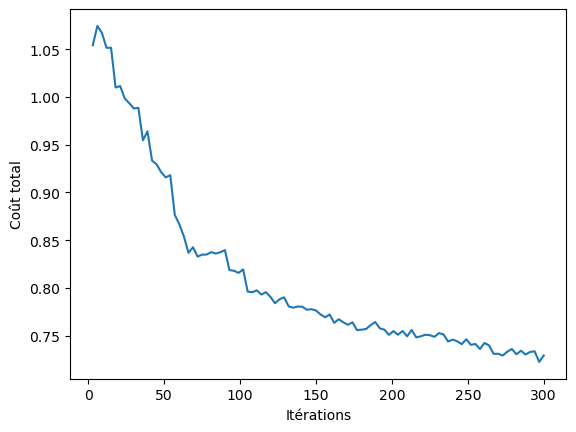

In [25]:
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Itérations')
plt.ylabel('Coût total')
plt.show()

On récupère les paramètres optimaux créer le circuit d'intelligence artificielle.

In [26]:
optimal_parameters = results.x

## Calcul de la justesse du modèle

Il reste à faire des prédictions avec les données d'entraînement et de test. Afin de tester le modèle d'intelligence artificiemme, il va falloir créer les circuits qui correspondent aux données d'entraînement et les circuits pour les données de test. Commençons par reproduire l'itération avec les données d'entraînement.

In [30]:
# Génération du circuit archétype
circuit_pattern = generate_circuit_pattern(feature_map, ansatz)

# Génération des circuits
circuits_train = [
    hydrate_circuit_pattern_with_data_and_tunable_parameters(
        circuit_pattern,
        feature_map.ordered_parameters,
        ansatz.ordered_parameters,
        data,
        optimal_parameters
    ) for data in X_train
]

pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuits = [pass_manager.run(circuit) for circuit in circuits_train]

# Exécution des circuits sur un ordinateur
sampler = Sampler(mode=backend)
job = sampler.run(isa_circuits)
results = job.result()

# Comparaison des prédictions avec les labels attendus
for y_true in y_train:
    y_pred = [max(label_probabilities(result), key=label_probabilities(result).get) for result in results]
    
y_pred = np.array(y_pred)
y_train = np.array(y_train)

# Calcul de la justesse
count = 0
for index in range(len(y_train)):
    if y_pred[index] == y_train[index]:
        count += 1

accuracy_train = count / len(y_pred)

On calcule la justesse pour les données de test.

In [31]:
circuits_test = [
    hydrate_circuit_pattern_with_data_and_tunable_parameters(
        circuit_pattern,
        feature_map.ordered_parameters,
        ansatz.ordered_parameters,
        data,
        optimal_parameters
    ) for data in X_test
]

pass_manager = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuits = [pass_manager.run(circuit) for circuit in circuits_test]

sampler = Sampler(mode=backend)
job = sampler.run(isa_circuits)
results = job.result()

for y_true in y_test:
    y_pred = [max(label_probabilities(result), key=label_probabilities(result).get) for result in results]
    
y_pred = np.array(y_pred)
y_test = np.array(y_test)

count = 0
for index in range(len(y_test)):
    if y_pred[index] == y_test[index]:
        count += 1

accuracy_test = count / len(y_pred)

On observe les résultats.

In [32]:
print("La justesse pour les données d'entraînements: {accuracy_train}".format(accuracy_train = accuracy_train))
print("La justesse pour les données de test:         {accuracy_test}".format(accuracy_test = accuracy_test))

La justesse pour les données d'entraînements: 0.825
La justesse pour les données de test:         0.7666666666666667


On observe que le modèle est correct.